# Python Machine Learning library: XGBoost

## 0. Some recap


Supervised learning problem: classification, regression, ranking, recommendation.     
  




## 1. XGBoost Introduction

Optimised gradient-boosting machine learning library.      
Has API in several language: Python, R etc.       
Speed and performance is its key.       
Core XGBoost algorithm is parallelisable, it can harness all of the processing power of modern multi-core computers.     
Consistently outperforms single-algorithm methods in ML competition and has been shown to achieve state of the art performance on a variety of benchmark ML dataset.      

When to use XGBoost?     

Supervised ML task that fits:     
1) large number of training example (more than 1000 traning sample and less than 100 features)     
2) number of feature < number of training samples      
3) mixture of categorical and numerical features, or just numerical feature.     

When NOT to use XGBoost?    

1) Image recognition, computer vision or NLP (use Deep Learning instead)     
2) small training set (<100)      
3) training sample << no. of feature       


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#quick example, DON'T RUN

class_data = pd.read_csv("classification_data.csv")
X,y = class_data.iloc[:,:-1], class_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

#instantiate xgboost
xg_cl = xgb.XGBClassifier(objective="binary:logistic", n_estimators=10,seed=123)

xg_cl.fit(X_train,y_train)

preds = xg_cl.predict(X_test)

#accuracy of the trained model
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

## 2. XGBoost for Classification

Classification problem:     

When dealing with binary supervised learning problems, the AUC (Area under the Receiver Operating Characteristic (ROC)) is the most versatile and common evaluation metric used to judge the quality of a binary classification model. It is simply the probability that a randomly chosen positive data point will have a higher rank than a randomly chosen negative data point for the learning problem. Higher AUC = more sensitive, better performing model.      

When dealing with multi-class classification problem, it is common to use accuracy score (higher is better) or to look at overall confusion matrix to evaluate the quality of a model.   

### 2.1 Decision Tree (for classification problem here)

XGBoost is usually used with trees as base learner.     
At each node, a question will be asked.      
At the bottom, every possible decision will eventualy lead to a choice, some taking many fewer questions to get to those choice than others.      

Base learner: Any individual learning algorithm in an ensemble algorithm as a base learner.      

Decision trees are contructed iteratively (one decision at a time),     
until a stopping criterion is met (e.g. depth of tree reaches some pre-defined value).     
During construction, the tree is built one split at a time, and the way that a split is selected (that is, what feature to split on and the where in the feature's range of values to split) can vary, it involves a stategy that segregates the target values better. (put each target category into buckets that are increasingly dominated by just one category), until nearly all vaues within a given split are exclusively of one category or another.             

Each leaf will have a single category in the majority, or should be exclusively of one category.     

Individual decision trees in geneal are low-bias, high-variance learning model. (could be fairly accuracy, but not precise) i.e. they are good at learning relationships within any data we train them on, but they tend to overfit the data we use to train them on, and generalise on new data poorly.     

XBGoost uses CART as base learner. In contrast, CART contain real-valued score in each leaf, regardless of whether they are used for classification or regression. The real-value scores can then be thresholded to convert into categories for classification problems if necessary. 

### 2.2 Boosting

Boosting is not a specific ML algorithm, but a concept that can be applied to a set of machine leanring models (meta-algorithm).     

Specifically, it is an ensemble meta-algorithm primarily used to reduce any given single learner's variance and to convert many weak learners into an arbitrarily strong learner.      

Weak learner: any ML algorithm that is slighly better than chance.(e.g. dicision stump with depth = 1, a decision tree whose prediction are slighly better than 50%.).      

Strong learner: any algorithm that can be tuned to achieve arbitrarily good performance for some supervised learning problem.     

How boosting is accomplished:        
1) iteratively learning a set of weak models on subsets of the data.     
2) weighting each of their predictions according to each weak learner's performance.      
3) Combine the weighted predictions to obtain a single weighted prediction.      



## 3. DMatrix (and CV in XGBoost)

In XGBoost, the dataset is convert into an optimised data structure (for performance and efficiency).      

Normally, the input datasets will be converted into DMatrix on the fly.    

but when we used the XGBoost cv object (for cross validation), we have to first explicityly convert our data into a Dmatrix

In [ ]:
# DON'T RUN
# DMatrix and CV in XGBoost

class_data = pd.read_csv("classification_data.csv")
# DMatrix convert
# month_5_still_here is the binary target, last col in the dataset.
churn_dmatrix = xgb.DMatrix(data=class_data.iloc[:,:-1],label=class_data.month_5_still_here)

params = {"objective":"binary:logistic","max_depth":4}

# num_boost_round: how many trees we want to build
# output to be sotres as pd df
cv_results = xgb.cv(dtrain=churn_dmatrix,params=params, nfold=4, num_boost_round=10, metrics="error",as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))

## 4. XGBoost for Regression

In most case, root mean squared error (RMSE) or the mean absolute error (MAE) is used to evaluate the quality of a regression model.    

RMSE treats positive and negative error equally but punish larger differences between predicted and actual values much more than smaller ones.     

MAE simply sums the absolute differences between predicted and actual values across all samples (then take the mean). MAE is not affected by large difference as much as RMSE, it lacks some nice maths property and it is much less used as an evaluation metrics.      

Common regression algorithms: Linear regression, Decision trees (CART).

### 4.1 Objective (loss) functions and base learners

Loss function quantify how far off a prediction is form the actual result for a given data point.     
It maps the difference between estimated and true values for some collection of data.     
Goal: find the model that yields the minimum value of the loss function.     


Loss function has specific naming conventions in XGBoost:      
For regression model:         
reg:linear (use reg:squarederror now)      

For binary classification:      
reg:logistic (when we want just decision, not probability)     
binary:logistic (when we want probability rather than just decision)       

XGBoost want base learner (i.e. individual model in the ensemble) when combined create final prediciton that is non-linear.    

Each base learner should be good at distinguishing or predicting different parts of the dataset.      

Two kinds of base learner: tree (default, common, scikitlearn compatible function) and linear (not so). Because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train()     


Linear Base Learner:      
Simply a sum of linear terms, exactly as we will find in a linear or logistic regression model.      
When combining many of these base model into ensemble, we get a weighted sum of linear models, whihc is itself linear.    
Rarely used due to only linear behavior. We can just use linear model.      

Tree based learner:     
Uses decision tree as base model. The combination of these base model becomes a non linear function of each individual tree, which itself is nonlinear. Almost exclusively used in XGBoost.      



In [2]:
# tree as base learner: scikit-learn API
df_housing_prep = pd.read_csv("../Machine_Learning_basics/data/ames_housing_trimmed_processed.csv")
print(df_housing_prep.shape)
df_housing_prep.head()

(1460, 57)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [4]:
# tree as base learner: scikit-learn API
X,y = df_housing_prep.iloc[:,:-1],df_housing_prep.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=123)

#reg:linear is deprecated
# XGBoost uses Tree by default (booster="gbtree")
xg_reg = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=10,seed=123)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [5]:
# tree as base learner: scikit-learn API
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

RMSE: 78847.401758


In [13]:
# Linear base learner: scikit-learn API
X,y = df_housing_prep.iloc[:,:-1],df_housing_prep.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=123)

#convert to dmatrix, required by the learning API
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test = xgb.DMatrix(data=X_test,label=y_test)

# specify linear base leaner
params = {"booster":"gblinear", "objective":"reg:squarederror"}

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)

rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

RMSE: 40699.547726


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [7]:
# Evaluating model quality
# Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the housing data

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.488281      429.449371   142980.464844    1193.806011
1    102832.562500      322.503447   104891.398438    1223.161012
2     75872.621094      266.493573    79478.947265    1601.341377
3     57245.657226      273.633063    62411.919922    2220.151162
4     44401.291992      316.426590    51348.276367    2963.378029
4    51348.276367
Name: test-rmse-mean, dtype: float64


In [8]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.595703     668.167771  127634.185547   2404.009753
1    89770.031250     456.980559   90122.505860   2107.916842
2    63580.782226     263.442189   64278.558594   1887.552548
3    45633.181640     151.849960   46819.175781   1459.821980
4    33587.097656      87.003217   35670.655274   1140.613227
4    35670.655274
Name: test-mae-mean, dtype: float64


### 4.2 Regularisation and base learners in XGBoost

Loss function in XGBoost don't just take into account how close a model's predictions are to the actual value, but also how complex (i.e. regularisation)      

There are several parameters that can be tweaked in XGBoost to limit model complexity by altering the loss function:       

gamma: A parameter for tree base learners that controls whether a given node on a base learner will split based on the expected reduction in the loss that would occuring after performing the split, so higher values lead to fewer split.    

alpha: L1 regularisation. This regularsation term is a penalty on leaf weights rather than on feature wieghts, as is the case in linear or logistic regression. Higher alpha value lead to stronger L1 regularisation, which cuases many leaf weights in the base leanrers to go to 0.     

lambda: L2 regularisation on leaf weights. Much smoother penalty than L1 and causes leaf weights to smoothly decreses.      



In [9]:
#L1 regularisation in XGBoost
X,y = df_housing_prep.iloc[:,:-1],df_housing_prep.iloc[:,-1]
housing_dmatrix = xgb.DMatrix(data=X, label=y)

params = {"objective":"reg:squarederror", "max_depth":4}

l1_params = [1,10,100] #alpha values that we will try

rmses_l1 = []

for reg in l1_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params,nfold=4, num_boost_round=10, metrics="rmse", as_pandas=True, seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])
    
print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(l1_params,rmses_l1)),columns=["l1","rmse"]))

Best rmse as a function of l1:
    l1          rmse
0    1  35572.512695
1   10  35571.970703
2  100  35572.369140


In [10]:
# L2 regularisation
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  52275.355469
1   10  57746.060547
2  100  76624.617188


Visualizing individual XGBoost trees     

Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.          

XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

In [ ]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9, rankdir="LR")
plt.show()

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.      

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this

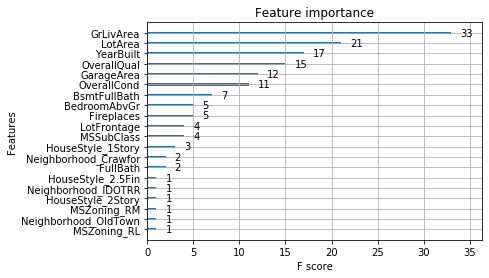

In [12]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

## 5. Tuning the XGBoost model

Example of tuned vs untuned parameters

In [30]:
#untuned example
X,y = df_housing_prep[df_housing_prep.columns.tolist()[:-1]],df_housing_prep[df_housing_prep.columns.tolist()[-1]]
housing_dmatrix = xgb.DMatrix(data=X,label=y)
untuned_params = {"objective":"reg:squarederror"}
untuned_cv_results_rmse = xgb.cv(dtrain=housing_dmatrix,params=untuned_params,nfold=4,metrics="rmse",as_pandas=True,seed=123)

print("untuned rmse: %f" % ((untuned_cv_results_rmse["test-rmse-mean"]).tail(1)))
#unit: dollars

untuned rmse: 34624.230957


In [31]:
# tuned model

#most important parameters in xgboost
tuned_params = {"objective":"reg:squarederror","colsample_bytree":0.3,"learning_rate":0.1, "max_depth":5}

tuned_cv_results_rmse = xgb.cv(dtrain=housing_dmatrix,params=tuned_params,nfold=4,num_boost_round=200,metrics="rmse",as_pandas=True,seed=123)

print("tuned rmse: %f" % ((tuned_cv_results_rmse["test-rmse-mean"]).tail(1)))

tuned rmse: 30370.555176


In [34]:
# tunning number of boosting rounds# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds          rmse
0                    5  50903.299479
1                   10  34774.191406
2                   15  32895.098307


Automated boosting round selection using early_stopping:     

Now, instead of attempting to cherry pick the best possible number of boosting rounds, you can very easily have XGBoost automatically select the number of boosting rounds for you within xgb.cv(). This is done using a technique called early stopping.        

Early stopping works by testing the XGBoost model after every boosting round against a hold-out dataset and stopping the creation of additional boosting rounds (thereby finishing training of the model early) if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds. Here you will use the early_stopping_rounds parameter in xgb.cv() with a large possible number of boosting rounds (50). Bear in mind that if the holdout metric continuously improves up through when num_boosting_rounds is reached, then early stopping does not occur.

In [35]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix,params=params,early_stopping_rounds=50,nfold=3,metrics="rmse",seed=123,as_pandas=True)

# Print cv_results
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141871.630208      403.632409   142640.630208     705.552907
1    103057.033854       73.787612   104907.677083     111.124997
2     75975.958333      253.705643    79262.057292     563.761707
3     57420.515625      521.666323    61620.138021    1087.681933
4     44552.960938      544.168971    50437.558594    1846.450522
5     35763.942708      681.796885    43035.660156    2034.476339
6     29861.469401      769.567549    38600.881511    2169.803563
7     25994.679036      756.524834    36071.816407    2109.801581
8     23306.832031      759.237670    34383.183594    1934.542189
9     21459.772786      745.623841    33509.141927    1887.374589


## 6. XGBoost's hyperparameters

The parameters that can be tuned are very different for each base learner.    

For Tree based learner:      

**learning rate (eta)**: affects how quickly the model fits the residual error using additional base learner. A low learning rate will require more boosting rounds to achieve the same reduction in residual error as an XGBoost model with a high learning reate.     

**gamma**: min loss reduction to create new tree split.      

**lambda**: L2 regulation on leaf weights      

**alpha**: L1 regulation on leaf weights      

**max_depth**: +ve integer and affects how deeply each tree is allowed to grow duirng any given boosting round.     

**subsample**: fraction of the total training set that can be used for any given boosting round.     

**colsample_bytree**: fraction of features you can select from during any given boosting round and must also be a value between 0 and 1. Smaller value can be thought as addition regularisation to the model.      

**num_boost_round**

For Linear Base Learner:     

**lambda**: L2 regulation on leaf weights      

**alpha**: L1 regulation on leaf weights      

**lambda_bias**: L2 regulation term on bias      

**num_boost_round**


In [36]:
# tuning learning rate: eta
# higher values of "eta" penalizing feature weights more strongly, causing much stronger regularization.

# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix,params=params,metrics="rmse",nfold=3,num_boost_round=10,early_stopping_rounds=5, as_pandas=True, seed=123)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

     eta      best_rmse
0  0.001  195736.406250
1  0.010  179932.161458
2  0.100   79759.401041


In [37]:
# tuning max_depth
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:squarederror"}

# Create list of max_depth values
max_depths = [2,5,10,20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depths"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix,params=params,metrics="rmse",nfold=2,num_boost_round=10,early_stopping_rounds=5, as_pandas=True, seed=123)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth     best_rmse
0          2  35922.513672
1          5  35922.513672
2         10  35922.513672
3         20  35922.513672


In [38]:
# tuning colsample_bytree
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
colsample_bytree_vals = [0.1,0.5,0.8,1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

   colsample_bytree     best_rmse
0               0.1  51386.587890
1               0.5  36585.345703
2               0.8  36093.660157
3               1.0  35836.042968


## 7. GridSearch and Random Search

Searching several hyperparameters simultaneously, leading to the lowest loss possible, when their values interact in non-obvious and non-linear way.     

Grid Search:     

Search exhaustively over a given set of hyperparameters, once per set of hyperparameters.      
If we have 2 hyperparameters would like to tune, then 4 possible values for each hyperparameter, then a grid search over that parameter space will try all 16 possible paramters configuration.      
Then pick final model hyperparameter values that gives best cv evaluation metric value.     



Random Search:      

The number of models that we are required to iterate does NOT grow as we expand the overall hyperparameter space.      
We decide how mnay models, or iteration, we want to try out before stopping.      
Random search simply involves drawing a random combination of possible hyperparameters values from the range of allowable hyperparameters a set number of times. Each time, we trian a model with the selected hyperparameters. evaluate the performances, and then repeat.       




In [39]:
#gridsearch example
from sklearn.model_selection import GridSearchCV

housing_dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {"learning_rate":[0.01,0.1,0.5,0.9],
                 "n_estimators":[200],
                 "subsample":[0.3,0.5,0.9]}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring="neg_mean_squared_error",cv=4,verbose=1)

grid_mse.fit(X,y)

print("Best parameters found:", grid_mse.best_params_)
print("Lowest RMSE found:", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[19:12:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:12:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   25.1s finished
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:12:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5}
Lowest RMSE found: 28410.039476552454


In [42]:
# random search example
from sklearn.model_selection import RandomizedSearchCV

housing_dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {"learning_rate":np.arange(0.05,1.05,.05),
                 "n_estimators":[200],
                 "subsample":np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid,n_iter=25,scoring="neg_mean_squared_error",cv=4,verbose=1)

randomized_mse.fit(X,y)

print("Best parameters found:", randomized_mse.best_params_)
print("Lowest RMSE found:", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[19:22:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:22:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.4s finished
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:22:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: {'subsample': 0.35000000000000003, 'n_estimators': 200, 'learning_rate': 0.15000000000000002}
Lowest RMSE found: 27959.816747233395


## 8. Pipeline for XGBoost

Pipeline:    
Takes a list of named 2-tupe(name,pipeline_step) as input, either transformer or estimator (compatible with sklearn).     

Can be used as input estimator intor grid/random search and cross_val_score method.


Some useful functions:     
LabelEncoder: converts a categorical col of string into integers (cannot be used in pipeline)        
OneHotEncoder: takes col of integers and encodes them as dummy variable (cannot be used in pipeline)        
DictVectorizer: converts list of feature mapping into vectors. Need to convert DataFrame into a list of dictionary entries

In [ ]:
#e.g. for a pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf_pipeline = Pipeline[("st_scaler", StandardScaler()),("rf_model",RandomForestRegressor())]

scores = cross_val_score(rf_pipeline,X,y, scoring="neg_mean_squared_error",cv=10)
final_avg_rmse = np.mean(np.sqrt(np.abs(scores)))
print("Final RMSE:", final_avg_rmse)

In [52]:
df_housing_raw = pd.read_csv("../Machine_Learning_basics/data/ames_unprocessed_data.csv")

In [48]:
df_housing_raw.shape

(1460, 21)

In [49]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Fill missing values with 0
df_housing_raw.LotFrontage = df_housing_raw.LotFrontage.fillna(0)

# Create a boolean mask for categorical columns
categorical_mask = (df_housing_raw.dtypes == object)

# Get list of categorical column names
categorical_columns = df_housing_raw.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df_housing_raw[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df_housing_raw[categorical_columns] = df_housing_raw[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df_housing_raw[categorical_columns].head())

  MSZoning Neighborhood BldgType HouseStyle PavedDrive
0       RL      CollgCr     1Fam     2Story          Y
1       RL      Veenker     1Fam     1Story          Y
2       RL      CollgCr     1Fam     2Story          Y
3       RL      Crawfor     1Fam     2Story          Y
4       RL      NoRidge     1Fam     2Story          Y
   MSZoning  Neighborhood  BldgType  HouseStyle  PavedDrive
0         3             5         0           5           2
1         3            24         0           2           2
2         3             5         0           5           2
3         3             6         0           5           2
4         3            15         0           5           2


In [51]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder: ohe
ohe = OneHotEncoder(categorical_features=categorical_mask,sparse=False)

# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded
df_encoded = ohe.fit_transform(df_housing_raw)

# Print first 5 rows of the resulting dataset - again, this will no longer be a pandas dataframe
print(df_encoded[:5, :])

# Print the shape of the original DataFrame
print(df_housing_raw.shape)

# Print the shape of the transformed array
print(df_encoded.shape)

[[0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 6.000e+01 6.500e+01 8.450e+03
  7.000e+00 5.000e+00 2.003e+03 0.000e+00 1.710e+03 1.000e+00 0.000e+00
  2.000e+00 1.000e+00 3.000e+00 0.000e+00 5.480e+02 2.085e+05]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 

/Users/XavierTang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/XavierTang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [54]:
# DictVectorizer
# Using a DictVectorizer on a DataFrame that has been converted to a dictionary allows you to get 
# label encoding as well as one-hot encoding in one go.

# Import DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# Convert df into a dictionary: df_dict
df_dict = df_housing_raw.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False)

# Apply dv on df: df_encoded
df_encoded = dv.fit_transform(df_dict)

# Print the resulting first five rows
print(df_encoded[:5,:])

# Print the vocabulary
print(dv.vocabulary_)

[[3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 2.000e+00 5.480e+02 1.710e+03 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  8.450e+03 6.500e+01 6.000e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 7.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.085e+05 2.003e+03]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 1.000e+00 2.000e+00 4.600e+02 1.262e+03 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.600e+03 8.000e+01 2.000e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 

In [ ]:
# pipeline
# Import necessary modules
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor())]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Fit the pipeline
xgb_pipeline.fit(X.to_dict("records"),y)

## 8.1 Incorporating xgboost into pipeline

We simply pass in an instance of the XGBoost regressor into the pipeline where a normal scikitlearn estimator would be.     

sklearn_pandas:     
a separte library.    
They have a generic class called DataFrameMapper, allows easy conversion between sklearn aware object or pure np array and DF. Another class called CategoricalImputer that will allow us to impute missing categorical values before conversion into integer directly.     



In [ ]:
#example, DON'T RUN
xgb_pipeline = Pipeline[("st_scaler", StandardScaler()),
                       ("xgb_model", xgb.XGBRegressor())]

scores = cross_val_score(xgb_pipeline, X,y, scoring="neg_mean_squared_error",cv=10)

In [ ]:
# hyperparameter tuning in a pipeline, DON'T RUN
xgb_pipeline = Pipeline[("st_scaler",StandardScaler()),("xgb_model",xgb.XGBRegressor())]

gbm_param_grid = {
    "xgb_model__subsample": np.arange(0.05,1,0.05),
    "xgb_model__max_depth": np.arange(3,20,1),
    "xgb_model__colsample_bytree": np.arange(0.01,1.05,0.05)
}

randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=gbm_param_grid, n_iter=10,
                                       scoring = "neg_mean_squared_error", cv=4)

randomized_neg_mse.fit(X,y)

np.sqrt(np.abs(randomized_neg_mse.best_score_))

randomized_neg_mse.best_estimator_